# 1. Embedding

<img src="https://nlpinkorean.github.io/images/transformer/transformer_positional_encoding_vectors.png" width="80%" align="center">

- 트랜스포머의 입력에서 제일 처음 거치는 Embedding 부분
- 위 그림처럼, 모델에 입력되는 최종 embedding은 다음의 2가지 embedding을 더하는 방식으로 만들어짐
    - Input Embedding: 단어를 벡터로 표현하는 embedding
    - Positional Embedding: 문장에 각 단어의 순서를 알려주는 embedding

In [ ]:

import torch
import torch.nn as nn

# source / target sequence 예시
inp = torch.tensor(
    [[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
     [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]], dtype=torch.long)
print(inp.size())
print(inp)

# # 64개의 단어로 이루어진 2개의 문장이 있다고 가정
# inp = torch.randint(10000, (2, 64)).type(torch.long)
# print(inp.shape)

torch.Size([2, 8])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])


## 1.1 Input Embedding

- 일반적으로 사용하는 `torch.nn.Embedding`을 통해 구현

In [ ]:
# 단어사전 크기
n_vocab = 10000

# Embedding vector의 차원
d_model = 512

inp_embed_layer = nn.Embedding(n_vocab, d_model, padding_idx=0)

inp_embedding = inp_embed_layer(inp)
print(inp_embedding.size())

torch.Size([2, 8, 512])


## 1.2 Positional Encoding

$$PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{\text{model}}})$$
$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{\text{model}}})$$


- 논문에 나온 위의 2개 식에 따라 값을 구한다.
- $d_{model}$ : embedding vector의 차원
- $i$ : embedding에서 dimension 위치를 나타내며, 짝수($2i$)에는 sin 값을 계산하고 홀수($2i + 1$)에는 cos값을 계산한다.
    - $d_{model}$이 512라면 $i$는 0~255사이의 값이 되고, 각각 sin, cos를 구해 총 512개의 값을 구할 수 있다.
- $pos$ : sequence에 있는 각 word의 위치
- [참고 링크](https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model)의 vote많은 2번째 답변 참고하기

In [ ]:
import numpy as np

# Positional encoding을 가져오는 함수
def get_pos_encoding(len_seq, d_model):
    # 결과를 담을 행렬 생성
    result_mat = np.zeros((len_seq, d_model))

    # pos와 나눌 분모 값 계산
    angle_div = [np.power(10000, ((2 * i) / d_model)) for i in range(d_model // 2)]

    # pos를 iterate하며 sine, cosine 값 계산
    for pos in range(len_seq):
        pe_sin = [np.sin(pos / div) for div in angle_div]
        pe_cos = [np.cos(pos / div) for div in angle_div]

        # 결과 행렬에 저장
        result_mat[pos, 0::2] = pe_sin # 0, 2, 4, ... (짝수)
        result_mat[pos, 1::2] = pe_cos # 1, 3, 5, ... (홀수)
    
    return result_mat

(64, 512)


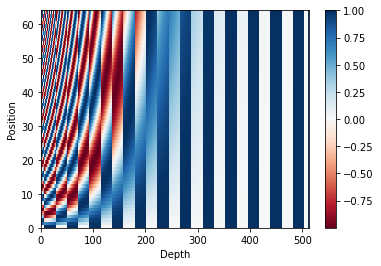

In [ ]:
import matplotlib.pyplot as plt

# 한 문장이 64개의 단어로 이루어지고, 각 단어는 512 차원의 임베딩벡터로 이루어질 경우 (논문의 예)
mat = get_pos_encoding(len_seq=64, d_model=512)
print(mat.shape)

plt.pcolormesh(mat, cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

(8, 512)


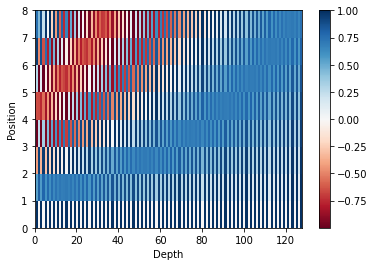

In [ ]:
# 여기서 예시로 간단히 사용한 8개의 단어로 이루어지고, 각 단어는 512 차원의 임베딩벡터로 이루어질 경우
mat = get_pos_encoding(len_seq=inp.size(1), d_model=512)
print(mat.shape)

plt.pcolormesh(mat, cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

## 1.3 Input Embedding + Positional Encoding

- 앞서 구한 input embedding과 positional encoding 값을 더해서 모델에 입력으로 들어갈 벡터를 생성
- 문장이 끝나서 0으로 패딩된 부분을 따로 0으로 만들어주고 이를 위해 1을 더하는 코드는 hugging face에는 없었으며, 1을 더하면 인덱스가 넘어가서 에러가 남 (물론 행렬을 그냥 크게 만들면 돌아는 가겠지만, 맞지 않는 것 같아 제외하였음) ([참고 소스코드](https://github.com/huggingface/transformers/blob/455c6390938a5c737fa63e78396cedae41e4e87e/src/transformers/modeling_distilbert.py#L87))

In [ ]:
# 먼저, positional encoding을 계산
pos_encoding = get_pos_encoding(inp.size(1), 128)
pos_encoding = torch.FloatTensor(pos_encoding)
print(pos_encoding.size())

torch.Size([8, 128])


In [ ]:
# 앞서 구한 positional encoding으로 embedidng layer를 초기화하고 freeze
pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

# pos_embed_layer에서 값을 꺼내오기 위한 position sequence 생성
positions = torch.arange(inp.size(1)).expand(inp.size(0), inp.size(1))
print(positions)

# input embedding과 더해줄 positional embedding 생성
pos_embedding = pos_embed_layer(positions)
print(pos_embedding.size())

tensor([[0, 1, 2, 3, 4, 5, 6, 7],
        [0, 1, 2, 3, 4, 5, 6, 7]])
torch.Size([2, 8, 128])


### 총정리 : 입력에서 input emb + positional emb = final emb까지

In [ ]:
# inp = torch.LongTensor(
#     [[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
#      [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
# print(inp.size())

In [ ]:
n_vocab = 10000
d_model = 512
max_len_seq = inp.size(1) # 8

inp_embed_layer = nn.Embedding(n_vocab, d_model, padding_idx=0)
pos_embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(get_pos_encoding(max_len_seq, d_model)),
                                               freeze=True)

print(inp_embed_layer)
print(pos_embed_layer)
print(pos_embed_layer.weight.requires_grad)

Embedding(10000, 512, padding_idx=0)
Embedding(8, 512)
False


In [ ]:
inp_embedding = inp_embed_layer(inp)
print(inp_embedding.size())

torch.Size([2, 8, 512])


In [ ]:
positions = torch.arange(inp.size(1)).expand(inp.size(0), inp.size(1))
pos_embedding = pos_embed_layer(positions)
print(pos_embedding.size())

torch.Size([2, 8, 512])


In [ ]:
final_embedding = inp_embedding + pos_embedding
print(final_embedding.shape)

torch.Size([2, 8, 512])


# 2. Multi-Head Attention

<img src="https://nlpinkorean.github.io/images/transformer/self-attention-matrix-calculation.png" width="50%">

<img src="https://nlpinkorean.github.io/images/transformer/self-attention-matrix-calculation-2.png" width="50%">

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        
        # attention head 갯수
        self.n_head = n_head

        # 각 head당 차원
        self.d_head = d_model // n_head

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask):
        # Q, K, V 생성
        # (bs, len_seq, n_head * d_head)
        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)

        # Q, K, V를 각 attention head로 분리
        # (bs, len_seq, n_head * d_head)
        Q = Q.view(Q.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = K.view(K.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = V.view(V.size(0), -1, self.n_head, self.d_head).permute(0, 2, 1, 3)

        # Z = Q * K^T / sqrt(d_head)
        # (bs, n_head, len_seq, d_head)
        Z = torch.matmul(Q, K.permute(0, 1, 3, 2)) / torch.sqrt(torch.FloatTensor([self.d_head]))

        # 마스크 씌워야하는 지점 (masked라면)
        # (bs, n_head, len_seq, d_head)
        Z.masked_fill_(mask, -1e10)

        # Z = softmax(Z) * V
        # (bs, n_head, len_seq, d_head)
        Z = torch.matmul(self.softmax(Z), V)

        # n_head랑 len_seq차원 위치 변경
        # (bs, n_head, len_seq, d_head)
        Z = Z.permute(0, 2, 1, 3).contiguous()

        # head 나눠져있던것 합치기
        # (bs, len_seq, n_head, d_head)
        Z = Z.view(Z.size(0), -1, self.d_head * self.n_head)
        
        # 마지막 linear layer 적용
        # (bs, len_seq, n_head * d_head)
        out = self.linear(Z)

        # 결과 출력
        # (bs, len_seq, n_head * d_head)
        return out

In [ ]:
# 앞에서 계산한 최종 임베딩이 입력이라고 가정
X = final_embedding
print(X.size())

att = MultiHeadAttention(d_model=512, n_head=8)
out = att(X, X, X, src_mask)
print(out.size())

torch.Size([2, 8, 512])
torch.Size([2, 8, 512])


# 3. Masked Multi-Head Attention


In [ ]:
# source 문장의 <pad> 토큰에 대해 0으로된 마스크 생성
def get_src_mask(src, pad_idx=0):
    # src shape: (batch_size, seq_len)
    
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    src_mask.logical_not_() # 0이 되어야 할 위치에 True가 오도록 True <-> False 반전
    # (batch_size, 1, 1, src_len)
    return src_mask


src_mask = get_src_mask(src=inp, pad_idx=0)
print(src_mask.size())
print(src_mask)

torch.Size([2, 1, 1, 8])
tensor([[[[False, False, False, False, False, False,  True,  True]]],


        [[[False, False, False, False, False, False, False, False]]]])


In [ ]:
# target 문장에서 다음 단어에 대해 0으로된 마스크 생성(다음 단어를 모르게하여 cheating 방지)
# target 문장에도 <pad> 토큰이 있을 수 있으므로, 같이 고려함
def get_trg_mask(trg, pad_idx=0):
    # trg shape: (batch_size, seq_len)

    trg_pad_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(2)
    # (batch_size, 1, 1, seq_len)

    seq_len = trg.size(1)
    trg_sub_mask = torch.tril(torch.ones((seq_len, seq_len))).bool()
    # (seq_len, seq_len)
    
    trg_mask = trg_pad_mask & trg_sub_mask
    trg_mask.logical_not_() # 0이 되어야 할 위치에 True가 오도록 True <-> False 반전
    # (bs, 1, seq_len, seq_len)

    return trg_mask


trg_mask = get_trg_mask(trg=inp, pad_idx=0)
print(trg_mask.size())
print(trg_mask)

torch.Size([2, 1, 8, 8])
tensor([[[[False,  True,  True,  True,  True,  True,  True,  True],
          [False, False,  True,  True,  True,  True,  True,  True],
          [False, False, False,  True,  True,  True,  True,  True],
          [False, False, False, False,  True,  True,  True,  True],
          [False, False, False, False, False,  True,  True,  True],
          [False, False, False, False, False, False,  True,  True],
          [False, False, False, False, False, False,  True,  True],
          [False, False, False, False, False, False,  True,  True]]],


        [[[False,  True,  True,  True,  True,  True,  True,  True],
          [False, False,  True,  True,  True,  True,  True,  True],
          [False, False, False,  True,  True,  True,  True,  True],
          [False, False, False, False,  True,  True,  True,  True],
          [False, False, False, False, False,  True,  True,  True],
          [False, False, False, False, False, False,  True,  True],
          [False, F

In [ ]:
# 앞에서 계산한 최종 임베딩이 입력이라고 가정
X = final_embedding
print(X.size())

src_mask = get_src_mask(src=inp, pad_idx=0)
out = att(X, X, X, mask=src_mask)
print(out.size())

trg_mask = get_trg_mask(trg=inp, pad_idx=0)
out = att(X, X, X, mask=trg_mask)
print(out.size())

torch.Size([2, 8, 512])
torch.Size([2, 8, 512])
torch.Size([2, 8, 512])


# 4. Feed Forward Network

$$\text{FFN}(x) = \max(0, xW_1+ b_1)W_2 + b_2$$


In [ ]:
class PoswiseFeedForward(nn.Module):
    def __init__(self, d_model, ratio):
        super().__init__()
        self.hidden_layer = nn.Linear(d_model, d_model*4)
        self.active = nn.ReLU()
        self.drop = nn.Dropout(ratio)
        self.output_layer = nn.Linear(d_model*4, d_model)

    def forward(self, input):
        X = self.hidden_layer(input)
        X = self.active(X)
        X = self.drop(X)
        return self.output_layer(X)

In [ ]:
pff = PoswiseFeedForward(d_model=512, ratio=0.1)
out = pff(out)
print(out.size())

torch.Size([2, 8, 512])


# 5. Encoder

## Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, drop_ratio):
        super().__init__()
        self.att = MultiHeadAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model)
        self.pff = PoswiseFeedForward(d_model, drop_ratio)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_ratio)
    
    def forward(self, input, mask):
        X = self.att(input, input, input, mask=mask)
        att_out = self.norm1(self.dropout(X) + input)

        X = self.pff(att_out)
        out = self.norm2(self.dropout(X) + att_out)
        return out

In [ ]:
# 앞에서 계산한 최종 임베딩이 입력이라고 가정
X = final_embedding
print(X.size())

encorder_layer = EncoderLayer(512, 8, 0.2)
mask = get_src_mask(src=inp, pad_idx=0)
out = encorder_layer(X, mask)
print(out.size())

torch.Size([2, 8, 512])
torch.Size([2, 8, 512])


## Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_head, drop_ratio, n_layer, n_vocab, max_len_seq):
        super().__init__()
        self.d_model = d_model
        self.word_embed_layer = nn.Embedding(n_vocab, d_model, padding_idx=0)
        pos_encoding = torch.FloatTensor(get_pos_encoding(max_len_seq, d_model))
        self.pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
        self.dropout = nn.Dropout(drop_ratio)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_head, drop_ratio) for _ in range(n_layer)])

    def forward(self, enc_input, src_mask):
        word_embedding = self.word_embed_layer(enc_input)

        positions = torch.arange(enc_input.size(1)).expand(enc_input.size(0), enc_input.size(1))
        pos_embedding = self.pos_embed_layer(positions)

        X = self.dropout(word_embedding + pos_embedding)

        for layer in self.encoder_layers:
            X = layer(X, src_mask)

        return X

In [ ]:
print(inp)
print(inp.shape)

encoder = Encoder(d_model=512, n_head=8, drop_ratio=0.1, n_layer=6, n_vocab=n_vocab, max_len_seq=max_len_seq)
out = encoder(inp, src_mask)
print(out.shape)

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
torch.Size([2, 8])
torch.Size([2, 8, 512])


# 6. Decoder


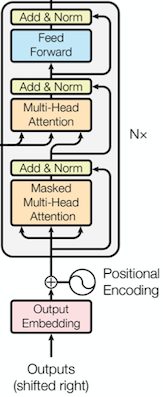

## decoder layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, drop_ratio):
        super().__init__()
        self.self_att = MultiHeadAttention(d_model, n_head)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_att = MultiHeadAttention(d_model, n_head)
        self.norm2 = nn.LayerNorm(d_model)
        self.pff = PoswiseFeedForward(d_model, drop_ratio)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_ratio)
    
    def forward(self, dec_input, enc_output, src_mask, trg_mask):
        X = self.self_att(dec_input, dec_input, dec_input, mask=trg_mask)
        self_att_out = self.norm1(self.dropout(X) + dec_input)

        X = self.enc_dec_att(self_att_out, enc_output, enc_output, mask=src_mask)
        enc_dec_att_out = self.norm2(self.dropout(X) + self_att_out)

        X = self.pff(enc_dec_att_out)
        out = self.norm3(self.dropout(X) + enc_dec_att_out)
        return out
        

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_model, n_head, drop_ratio, n_layer, n_vocab, max_len_seq):
        super().__init__()
        self.d_model = d_model
        self.word_embed_layer = nn.Embedding(n_vocab, d_model, padding_idx=0)
        pos_encoding = torch.FloatTensor(get_pos_encoding(max_len_seq, d_model))
        self.pos_embed_layer = nn.Embedding.from_pretrained(pos_encoding, freeze=True)
        self.dropout = nn.Dropout(drop_ratio)
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_head, drop_ratio) for _ in range(n_layer)])

    def forward(self, dec_input, enc_output, src_mask, trg_mask):
        word_embedding = self.word_embed_layer(dec_input)

        positions = torch.arange(dec_input.size(1)).expand(dec_input.size(0), dec_input.size(1))
        pos_embedding = self.pos_embed_layer(positions)

        X = self.dropout(word_embedding + pos_embedding)

        for layer in self.decoder_layers:
            X = layer(X, enc_output, src_mask, trg_mask)

        return X

## Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, enc_vocab_size, enc_pad_idx, enc_seq_len,
                 dec_vocab_size,  dec_pad_idx, dec_seq_len,
                 *, d_model=512, n_head=8, drop_ratio=0.1, n_layer=6):
        super().__init__()
        self.enc_pad_idx = enc_pad_idx
        self.dec_pad_idx = dec_pad_idx
        self.encoder = Encoder(d_model, n_head, drop_ratio, n_layer, enc_vocab_size, enc_seq_len)
        self.decoder = Decoder(d_model, n_head, drop_ratio, n_layer, dec_vocab_size, dec_seq_len)
        self.linear = nn.Linear(d_model, dec_vocab_size)

    def forward(self, X, Y):
        src_mask = get_src_mask(X, pad_idx=self.enc_pad_idx)
        trg_mask = get_trg_mask(Y, pad_idx=self.dec_pad_idx)

        enc_output = self.encoder(X, src_mask)
        dec_output = self.decoder(Y, enc_output, src_mask, trg_mask)
        out = self.linear(dec_output)
        return out

# Data

In [ ]:
!pip install konlpy
!pip install sentencepiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df_origin = pd.read_excel('/content/drive/MyDrive/ko_en_190920.xlsx')
df_origin

,Temp,한국어,영어,영어 검수
0,15005,나는 네가 한국 언어를 배워서 한국어로 대화했으면 좋겠어.,I want you to learn Korean and talk with me in...,I want you to learn Korean so that we can talk...
1,15006,나는 대략 한 시간 정도 이 창고를 돌아 보기를 원합니다.,I want to look around this warehouse for about...,I want to look around this warehouse for about...
2,15007,때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?,"I want to experience Korean skin peeling, but ...",I want to experience a Korean skin peeling bat...
3,15008,우리들 또한 당신들과 함께 한다면 큰 영광일 것입니다.,It will be truly honored for us to work with you.,It will be truly honored for us to work with you.
4,15016,나는 네가 한국의 감탄사를 사용한다는 말에 놀랐다.,I was surprised that you used Korea's exclamat...,I was surprised to hear that you are using Kor...
...,...,...,...,...
9994,2229,아침에 물 흐르는 좋은 소리를 들었습니다.,I heard the water is running in the morning.,I heard the water flows in the morning.
9995,2240,Anne은 여름 휴가를 어떻게 보낼 것인가요?,How will Anne spend the summer vacation?,What is Anne's plan for the summer vacation?
9996,2242,이번 여름 휴가는 일본에 가려고 했어요.,I have planned to go Japan this summer vacation.,I had a plan to go to Japan this summer vacation.
9997,2243,설 연휴 휴무 일정이 어떻게 되나요?,What are the New Year’s holiday schedules?,When is the New Year’s holiday?


In [ ]:
from konlpy.tag import Okt

class OktTokenizer(Okt):
    def __init__(self, sentences):
        super().__init__()
        
        words = set()
        max_len = 0
        for sentence in sentences:
            morphs = self.morphs(sentence)
            max_len = max(len(morphs), max_len)
            words.update(morphs)

        self.max_len = max_len
        self.vocab_size = len(words) + 1
        self.word_to_index = {word:index for index, word in enumerate(words, start=1)}
        self.word_to_index[0] = '<PAD>'
        self.index_to_word = {index:word for word, index in self.word_to_index.items()}
        
    
    def encode(self, sentence):
        morphs = self.morphs(sentence)
        morphs = [self.word_to_index[word] for word in morphs]
        morphs.extend([0] * (self.max_len - len(morphs)))
        return morphs
    
    
    def decode(self, sentence):
        return ' '.join(self.index_to_word[i] if i!=0 else '<PAD>' for i in sentence)

In [ ]:
ko_tokenizer = OktTokenizer(df_origin['한국어'])

In [ ]:
f'토큰화된 단어의 개수 : {ko_tokenizer.vocab_size}'

'토큰화된 단어의 개수 : 12285'

In [ ]:
a = ko_tokenizer.encode('때를 미는 한국의 목욕법을 체험해보고 싶은데 가능할까요?')
print(a)

[10041, 7758, 1647, 6613, 6367, 7776, 11196, 5871, 11580, 6310, 2209, 2615, 4407, 11491, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
ko_tokenizer.decode(a)

'때 를 미는 한국 의 목욕 법 을 체험 해보고 싶은데 가능할까 요 ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [ ]:
en_data = df_origin['영어 검수'].map(lambda s: s.lower())

In [ ]:
with open('/content/drive/MyDrive/en_translate.txt','w') as w:
    w.write('\n'.join(en_data))

In [ ]:
words = set()
en_data.map(lambda s: words.update([w for w in s.split()]))
print(words)
len(words)

{'viewed', 'black', 'file.', 'whole.', 'groom', 'cell-phone', 'highlight', 'sand', 'rail', 'walk.', 'rare,', 'dock', 'stands', 'avoid', 'alone,', 'thoughtlessly.', 'deficient', 'behavior', 'nikola.', 'breast-feed', 'hongkong?', 'surprised.', 'so', 'accounting.', 'games', 'have?', 'wholesale', 'gorging', 'beautiful.', 'tears', 'self-defense.', 'into.', 'kyushu.', 'insight.', 'dancers', 'benefits', 'peace', 'easily', 'pointillism.', 'cartoon.', 'sky', 'blind', 'pe', 'omelette', 'put', 'ice.', 'repeatedly', 'clock.', 'offer', 'hotel,', 'caring', 'instrument.', 'revitalize', 'robot.', 'understands', 'styles.', 'proceeded.', '30.', 'adapting', 'excited', 'brother', 'boring,', 'quietly', 'harry', 'workers', 'invaded', 'valley', "island',", 'wore', 'jesus', "wife's", 'women.', 'families.', 'tulip.', 'data.', 'changed', 'rabbits', 'lightning', 'oiled', 'gift.', 'mount.', 'scarred.', 'media', 'listened', 'loud.', 'all,', 'boring.', 'trucks', 'mull', 'muscles', 'card,', 'parked', 'african-americ

11515

In [ ]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    f"--input=/content/drive/MyDrive/en_translate.txt --model_prefix=/content/drive/MyDrive/en_t --vocab_size=6000" + 
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]")  # end of sequence (3)
sp = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/en_t.model')

True

In [ ]:
class Tokenizer():
    def __init__(self, sp, sentences):
        self.sp = sp
        self.max_len = max([len(sp.encode_as_pieces(s)) for s in sentences]) + 2
        self.vocab_size = sp.vocab_size()
        

    def encode(self, sentence):
        morphs = ['[BOS]'] + list(self.sp.encode_as_pieces(sentence)) + ['[EOS]']
        morphs.extend(['[PAD]'] * (self.max_len - len(morphs)))
        return [self.sp.piece_to_id(word) for word in morphs]
    
    
    def decode(self, sentence):
        return ' '.join(self.sp.id_to_piece(i) if i < self.vocab_size else '[UNK]' for i in sentence)

In [ ]:
en_tokenizer = Tokenizer(sp, en_data.values)
print(en_tokenizer.max_len)
a = en_tokenizer.encode('When is the New Year’s holiday?'.lower())
print(a)

40
[2, 54, 12, 6, 188, 138, 1, 11, 755, 20, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
en_tokenizer.decode(a)

'[BOS] ▁when ▁is ▁the ▁new ▁year [UNK] s ▁holiday ? [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
ko_data = np.array(list(df_origin['한국어'].map(lambda s: ko_tokenizer.encode(s)).values))
en_data = np.array(list(df_origin['영어 검수'].map(lambda s: en_tokenizer.encode(s.lower())).values))
print(ko_data.shape)
print(en_data.shape)

(9999, 22)
(9999, 40)


In [ ]:
ko_train, ko_test = ko_data[:8000], ko_data[8000:]
en_train, en_test = en_data[:8000], en_data[8000:]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader(X, Y):
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=128)
    return dataloader

train_loader = create_dataloader(ko_train, en_train)
test_loader = create_dataloader(ko_test, en_test)

In [ ]:
INPUT_DIM = ko_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
HIDDEN_DIM = 512
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 2048
DEC_PF_DIM = 2048
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

BATCH_SIZE = 128

In [ ]:
SRC_PAD_IDX = 0
TRG_PAD_IDX = 0
SRC_SEQ_LEN = ko_tokenizer.max_len
TRG_SEQ_LEN = en_tokenizer.max_len

# Transformer 객체 선언
model = Transformer(INPUT_DIM, SRC_PAD_IDX, SRC_SEQ_LEN, OUTPUT_DIM, TRG_PAD_IDX, TRG_SEQ_LEN)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 56,578,416 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (word_embed_layer): Embedding(12285, 512, padding_idx=0)
    (pos_embed_layer): Embedding(22, 512)
    (dropout): Dropout(p=0.1, inplace=False)
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (att): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (softmax): Softmax(dim=-1)
          (linear): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (pff): PoswiseFeedForward(
          (hidden_layer): Linear(in_features=512, out_features=2048, bias=True)
          (active): ReLU()
          (drop): Dropout(p=0.1, inplace=False)
          (output_layer): Linear(in_features=2048, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, dataloader, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, (src, trg) in enumerate(dataloader):
        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, dataloader, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, (src, trg) in enumerate(dataloader):
            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_loader, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 19m 43s
	Train Loss: 6.263 | Train PPL: 524.694
	Validation Loss: 5.920 | Validation PPL: 372.481
Epoch: 02 | Time: 19m 16s
	Train Loss: 5.998 | Train PPL: 402.760
	Validation Loss: 5.938 | Validation PPL: 379.067
Epoch: 03 | Time: 18m 50s
	Train Loss: 5.962 | Train PPL: 388.507
	Validation Loss: 5.963 | Validation PPL: 388.945


KeyboardInterrupt: ignored

In [ ]:
ko = '번역이 잘되고 있습니까?'
ko_x = ko_tokenizer.encode(ko)
ko_x = torch.tensor([ko_x])
ko_x

tensor([[ 1635,  7073,  4080,  6558,  1036, 11491,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
en_y = torch.tensor([[2]])
en_y

tensor([[2]])

In [ ]:
model.eval()
output = model(ko_x, en_y)
output

tensor([[[-6.3804,  1.3508, -5.6542,  ..., -2.8601, -6.6494, -3.9829]]],
       grad_fn=<AddBackward0>)

In [ ]:
output.argmax(2)

tensor([[4]])